In [ ]:
seed = 101

In [ ]:
#IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn import preprocessing

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda,MaxPool2D
from keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
!pip install split-folders

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hosshass","key":"d143b1365dc9386ce551c6be8a1aa3d6"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

 97% 641M/658M [00:03<00:00, 204MB/s]
100% 658M/658M [00:03<00:00, 203MB/s]


In [ ]:
from zipfile import ZipFile

file_name="/content/plantdisease.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
	# printing all the contents of the zip file
	# zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')

Extracting all the files now...
Done!


Number of images of Tomato__Tomato_mosaic_virus: 373 || Number of images of Pepper__bell___healthy: 1478 || Number of images of Potato___Late_blight: 1000 || Number of images of Pepper__bell___Bacterial_spot: 997 || Number of images of Tomato_Septoria_leaf_spot: 1771 || Number of images of Tomato_Late_blight: 1909 || Number of images of Tomato_Early_blight: 1000 || Number of images of Tomato_Leaf_Mold: 952 || Number of images of Tomato_Spider_mites_Two_spotted_spider_mite: 1676 || Number of images of Tomato_healthy: 1591 || Number of images of Potato___Early_blight: 1000 || Number of images of Potato___healthy: 152 || Number of images of Tomato_Bacterial_spot: 2127 || Number of images of Tomato__Target_Spot: 1404 || Number of images of Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 || 

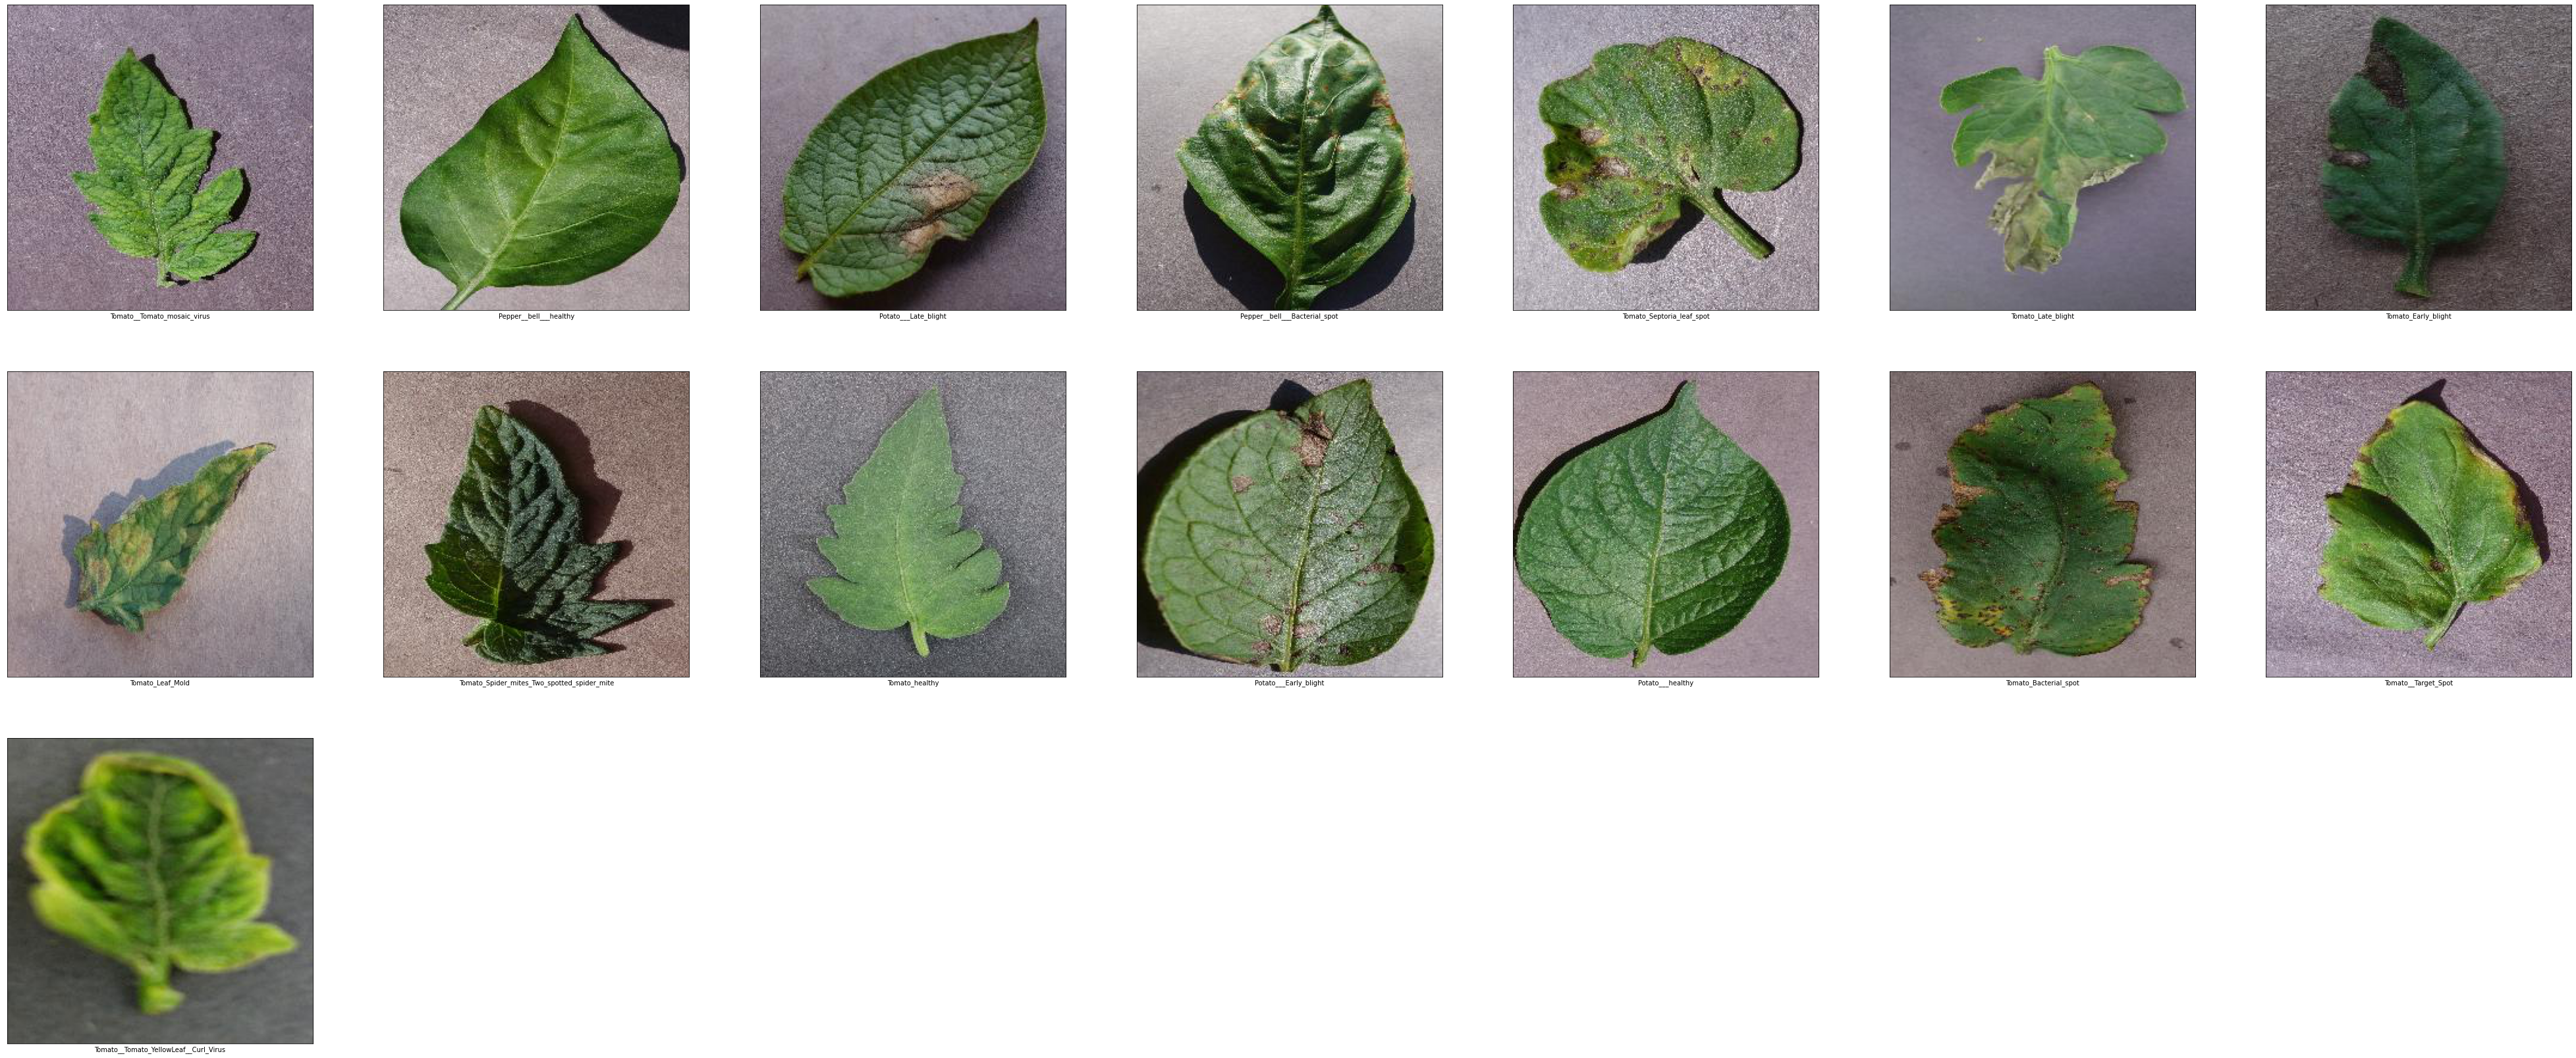

In [ ]:
path='/content/PlantVillage/'
plt.figure(figsize=(70,70))
count=0
plant_names=[]
total_images=0
for i in os.listdir(path):
  count+=1
  plant_names.append(i)
  plt.subplot(7,7,count)

  images_path=os.listdir(path+"/"+i)
  print("Number of images of "+i+":",len(images_path),"||",end=" ")
  total_images+=len(images_path)

  image_show=plt.imread(path+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.xlabel(i)
  
  plt.xticks([])
  plt.yticks([])

In [ ]:
print("Total number of images we have",total_images)

Total number of images we have 20639


In [ ]:
print(plant_names)

['Tomato__Tomato_mosaic_virus', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_healthy', 'Potato___Early_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [ ]:
print(len(plant_names))

15


In [ ]:
os.mkdir('train-test-val')

In [ ]:
import splitfolders
splitfolders.ratio('/content/PlantVillage/','/content/train-test-val',ratio=(.8,.1,.1),seed=seed,move=True)

Copying files: 20639 files [00:01, 12346.01 files/s]


In [ ]:
#Image augmentation
train_datagen= ImageDataGenerator(rotation_range = 40,
       rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,width_shift_range=0.2,height_shift_range=0.2)

val_datagen=ImageDataGenerator(rotation_range = 40,
       rescale=1./255,)

path_train='/content/train-test-val/train'

path_valid='/content/train-test-val/val'

train= train_datagen.flow_from_directory(directory=path_train,batch_size=64,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=seed)

valid=val_datagen.flow_from_directory(directory=path_valid,batch_size=64,target_size=(224,224),color_mode='rgb',class_mode='categorical',seed=seed)

Found 16505 images belonging to 15 classes.
Found 2057 images belonging to 15 classes.


In [ ]:
tes_datagen=ImageDataGenerator(rotation_range = 40,
       rescale=1./255,)
path_test='/content/train-test-val/test'

test= tes_datagen.flow_from_directory(directory=path_test,batch_size=64,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=seed)

Found 2076 images belonging to 15 classes.


In [ ]:
base_model_tf=tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#Model building
base_model_tf.trainable=False
x = base_model_tf.output
model_VGG16=BatchNormalization()(x)
model_VGG16=GlobalAveragePooling2D()(model_VGG16)
model_VGG16=Dense(1024,activation='relu')(model_VGG16)
model_VGG16=Dense(512,activation='relu')(model_VGG16)
model_VGG16=Dense(256,activation='relu')(model_VGG16)
model_VGG16=Dropout(.6)(model_VGG16)
model_VGG16=Dense(15,activation='softmax')(model_VGG16)

model_main=Model(inputs=base_model_tf.input,outputs=model_VGG16)
model_main.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

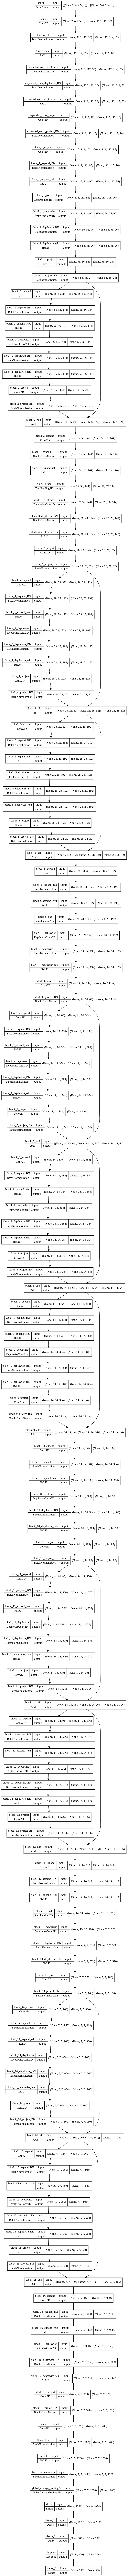

In [ ]:
keras.utils.plot_model(model_main, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
#CallBacks
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.0001)

In [ ]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Training
hist = model_main.fit(train,validation_data=valid,epochs=80,steps_per_epoch=200,verbose=1,callbacks=[mc,lr])

Epoch 1/80
200/200 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.7585
Epoch 1: val_accuracy improved from -inf to 0.86291, saving model to /content
INFO:tensorflow:Assets written to: /content/assets
200/200 [==============================] - 195s 911ms/step - loss: 0.7402 - accuracy: 0.7585 - val_loss: 0.4037 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 2/80
200/200 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.8516
Epoch 2: val_accuracy improved from 0.86291 to 0.88624, saving model to /content
INFO:tensorflow:Assets written to: /content/assets
200/200 [==============================] - 178s 891ms/step - loss: 0.4524 - accuracy: 0.8516 - val_loss: 0.3351 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 3/80
200/200 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8738
Epoch 3: val_accuracy improved from 0.88624 to 0.89256, saving model to /content
INFO:tensorflow:Assets written to: /content/assets
200/200 [==============

In [ ]:
model_main.save("Mobv2.h5")

In [ ]:
model_loss,modelAccuracy = model_main.evaluate(test,verbose=2)
print("model accuracy "+str(modelAccuracy))

33/33 - 23s - loss: 0.1038 - accuracy: 0.9706 - 23s/epoch - 686ms/step
model accuracy 0.9706165790557861


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'loss')

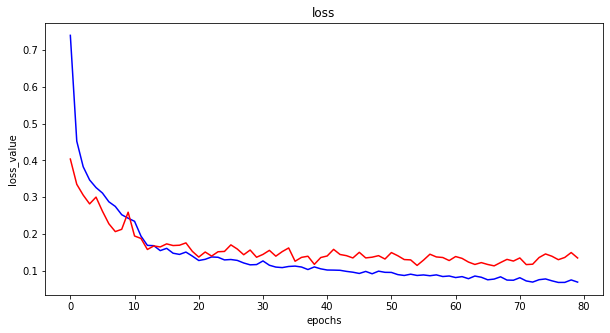

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'],color='b',label='Training loss')
plt.plot(hist.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss_value")
plt.title("loss")

Text(0.5, 1.0, 'accuracy graph')

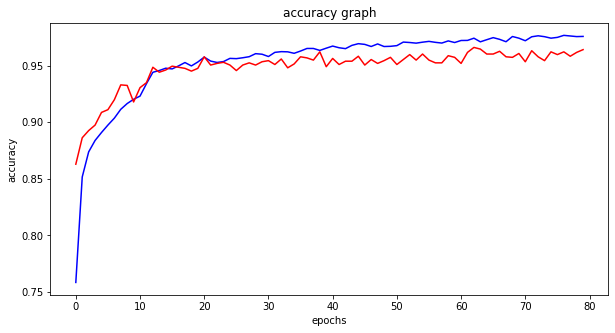

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['accuracy'],color='b',label='Training accuracy')
plt.plot(hist.history['val_accuracy'],color='r',label='Validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy graph")